In [1]:
import numpy as np 
import networkx as nx  
import matplotlib.pyplot as plt
from graph import GraphColoring
from vqe import GraphColorVQE
from grover import GraphColorGrover

In [2]:
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools.visualization import plot_histogram

### Oracle Composition

#### 1. Convert graph coloring problem into a set of constraints

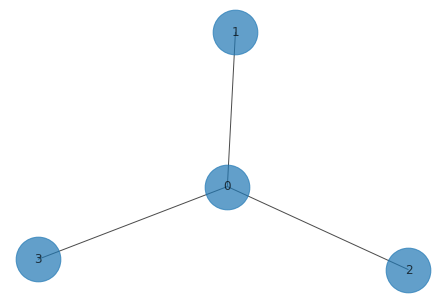

In [11]:
edges = [[0,1],[0,2],[0,3]]
g = GraphColoring(ncolors=2, edges=edges, nnodes=4) 
g.render_graph()

Constraints to select exactly one color for each node:

$ X_{00} \oplus X_{01} \\
   X_{10} \oplus X_{11} \\
   X_{20} \oplus X_{21} \\
   X_{30} \oplus X_{31} \\
$

Constraints to make sure linked nodes have different colors:

$ 
\lnot (X_{00} \land X_{10})\\
\lnot (X_{01} \land X_{11})\\
\lnot (X_{00} \land X_{20})\\
\lnot (X_{01} \land X_{21})\\
\lnot (X_{00} \land X_{30})\\
\lnot (X_{01} \land X_{31})\\
$


#### 2. Use Toffoli Gate to implement boolean constraints

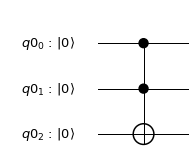

In [3]:
"""To implement q1 AND q2 simply apply Toffoli"""

q = QuantumRegister(3) 
qc = QuantumCircuit(q)

qc.ccx(q[0],q[1],q[2])
qc.draw(output='mpl')

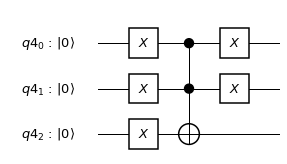

In [12]:
"""To implement q1 OR q2 convert expression to NOT( NOT(A) AND NOT(B)) and use Toffoli for the AND"""
q = QuantumRegister(3) 
qc = QuantumCircuit(q)

qc.x(q[0])
qc.x(q[1])
qc.x(q[2])
qc.ccx(q[0],q[1],q[2])
qc.x(q[0])
qc.x(q[1])

qc.draw(output='mpl')

### Example

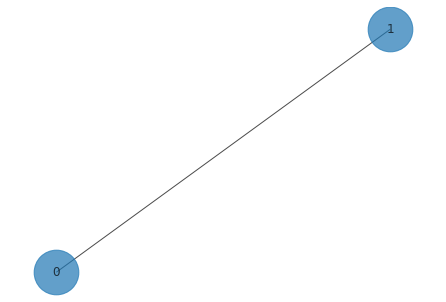

p cnf 4 6
-2 -1 0
1 2 0
-4 -3 0
3 4 0
-3 -1 0
-4 -2 0



In [53]:
edges = [[1,0]]
g = GraphColoring(ncolors=2, edges=edges, nnodes=2) 
g.render_graph()

groverGC = GraphColorGrover(g)
constraints = groverGC.graphcover_constraints()
CNF = groverGC.dimacs_format(constraints, groverGC.gc.nnodes*groverGC.gc.ncolors)
print(CNF)

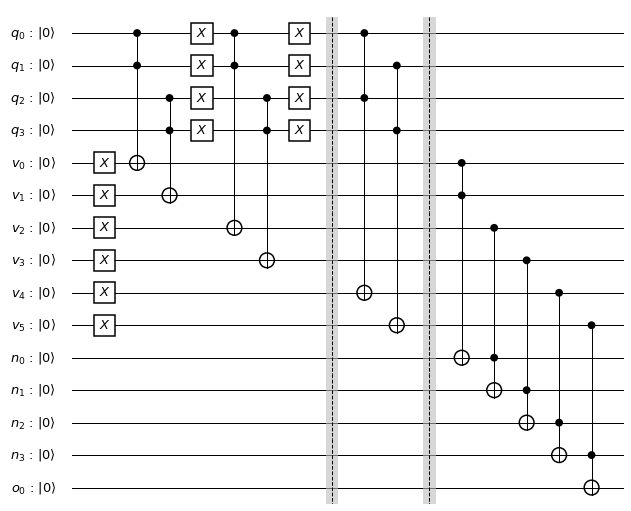

In [55]:
q = QuantumRegister(4, 'q') 
c = QuantumRegister(6, 'v') 
a = QuantumRegister(4, 'n') 
o = QuantumRegister(1, 'o') 
qc = QuantumCircuit(q, c, a, o)

qc.x(c[0])
qc.ccx(q[0],q[1],c[0])

qc.x(c[1])
qc.ccx(q[2],q[3],c[1])

qc.x(c[2])
qc.x(q[0])
qc.x(q[1])
qc.ccx(q[0],q[1],c[2])
qc.x(q[0])
qc.x(q[1])

qc.x(c[3])
qc.x(q[2])
qc.x(q[3]) 
qc.ccx(q[2],q[3],c[3])
qc.x(q[2])
qc.x(q[3])

qc.x(c[4])
qc.x(c[5])

qc.barrier()

qc.ccx(q[0],q[2],c[4])
qc.ccx(q[1],q[3],c[5])

qc.barrier() 

qc.ccx(c[0],c[1],a[0])
qc.ccx(c[2],a[0],a[1])
qc.ccx(c[3],a[1],a[2])
qc.ccx(c[4],a[2],a[3])
qc.ccx(c[5],a[3],o[0])

qc.draw(output='mpl', scale=.5)

### Grover on quantum simulation

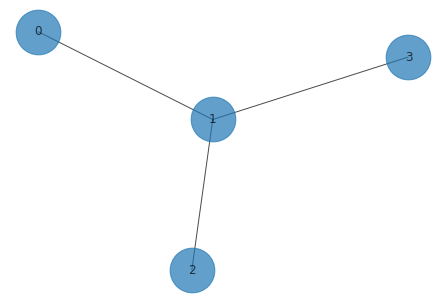

Graph coloring satisfied!
Oracle with number of qubits: 17


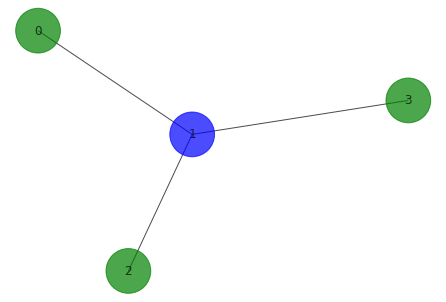

Graph coloring satisfied!


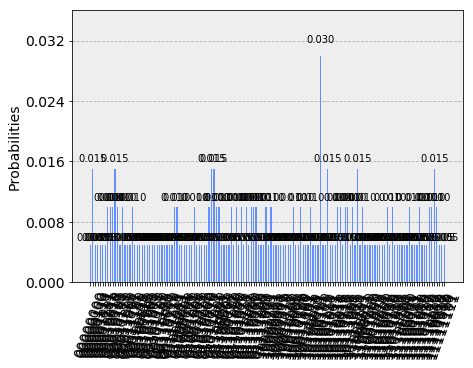

In [3]:
edges = [[1,0],[1,2],[1,3]]
g = GraphColoring(ncolors=2, edges=edges, nnodes=4) 
g.render_graph()

groverGC = GraphColorGrover(g, 200)
solution = groverGC.run_sim()

g.render_graph(solution)

plot_histogram(groverGC.result['measurement'])

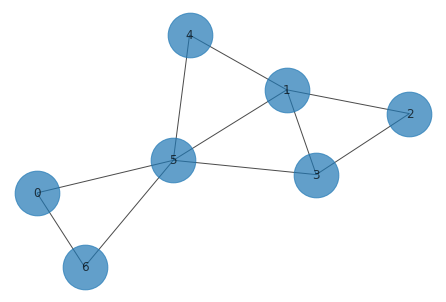

In [ ]:
edges = [[2, 1], [3, 1], [4, 1], [5, 0], [5, 3], [6, 0], [6, 5], [1,5], [4,5], [2,3]]
g = GraphColoring(ncolors=3, edges=edges, nnodes=7)
g.render_graph()

groverGC = GraphColorGrover(g, 200)
solution = groverGC.run_sim()

g.render_graph(solution)

### Grover on real device

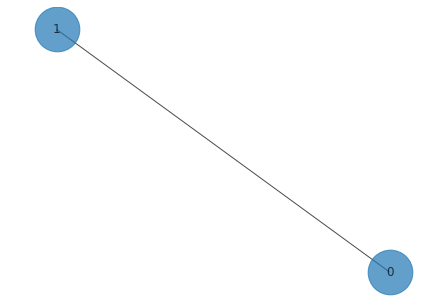

/Users/danielchafamo/Envs/BWH/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqprovider.py:255: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


Using backend: ibmq_16_melbourne


FAILURE: the 0-th qobj, job id: 5cd19c564458f3006e21cd0b Terra job error: "HTTPSConnectionPool(host='quantumexperience.ng.bluemix.net', port=443): Max retries exceeded with url: /api/Jobs/5cd19c564458f3006e21cd0b/status?access_token=pHiajeC4YfG1ASP0NtZfNT9CLPhOeOGloh9kZPvqFCqbH042NhWZZki1YTqU27D3 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x11e6be7b8>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))" 
FAILURE: job id: 5cd19c564458f3006e21cd0b, status: 'FAIL_TO_GET_STATUS' Terra job error: "HTTPSConnectionPool(host='quantumexperience.ng.bluemix.net', port=443): Max retries exceeded with url: /api/Jobs/5cd19c564458f3006e21cd0b/status?access_token=pHiajeC4YfG1ASP0NtZfNT9CLPhOeOGloh9kZPvqFCqbH042NhWZZki1YTqU27D3 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x11e6be0f0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known

ConnectionError: HTTPSConnectionPool(host='quantumexperience.ng.bluemix.net', port=443): Max retries exceeded with url: /api/Backends/v/1?access_token=pHiajeC4YfG1ASP0NtZfNT9CLPhOeOGloh9kZPvqFCqbH042NhWZZki1YTqU27D3 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x11a30ef28>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [25]:
edges = [[1,0]]
g = GraphColoring(ncolors=2, edges=edges, nnodes=2) 
g.render_graph()

groverGC = GraphColorGrover(g)
solution = groverGC.run_on_IBMQ()

g.render_graph(solution)

groverGC.visualize(groverGC.result)

In [3]:
groverGC.result

{'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1189f3d30>,
 'measurement': {'1110': 3,
  '1001': 13,
  '0001': 9,
  '1111': 1,
  '1101': 13,
  '0010': 1,
  '0101': 10,
  '0100': 15,
  '1011': 1,
  '1000': 13,
  '1100': 12,
  '0111': 1,
  '0000': 8},
 'top_measurement': '0100',
 'result': [-1, -2, 3, -4],
 'oracle_evaluation': False}